* [The spelled-out intro to language modeling: building makemore by Andrej Karpathy](https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3&ab_channel=AndrejKarpathy)
* [Makemore part 1 GitHub: Andrej Karpathy](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part1_bigrams.ipynb)

# Dataset

In [1]:
import requests
from pathlib import Path

file_path = Path("../data") / "names.txt"
file_path.parent.mkdir(exist_ok=True)
if file_path.exists():
    with open(file_path, mode="r", encoding="utf-8") as f:
        text = f.read()
else:
    text = requests.get("https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt").text
    with open(file_path, mode="w", encoding="utf-8") as f:
        f.write(text)

words = text.split()
print(f"# words: {len(words)}")
lens = [len(w) for w in words]
print(f"min, max len of words: {min(lens), max(lens)}")
print(words[:16])

# words: 32033
min, max len of words: (2, 15)
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella', 'avery']


# Bigram freqs

In [2]:
bigram_freqs = {}
for w in words:
    chrs = ["<S>"] + list(w) + ["<E>"]
    for i in range(len(chrs) - 1):
        bigram = (chrs[i], chrs[i+1])
        bigram_freqs[bigram] = bigram_freqs.get(bigram, 0) + 1

print(f"# unique bigrams: {len(bigram_freqs)}")
print(bigram_freqs)
sorted_bigrams = sorted(bigram_freqs.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_bigrams)

# unique bigrams: 627
{('<S>', 'e'): 1531, ('e', 'm'): 769, ('m', 'm'): 168, ('m', 'a'): 2590, ('a', '<E>'): 6640, ('<S>', 'o'): 394, ('o', 'l'): 619, ('l', 'i'): 2480, ('i', 'v'): 269, ('v', 'i'): 911, ('i', 'a'): 2445, ('<S>', 'a'): 4410, ('a', 'v'): 834, ('v', 'a'): 642, ('<S>', 'i'): 591, ('i', 's'): 1316, ('s', 'a'): 1201, ('a', 'b'): 541, ('b', 'e'): 655, ('e', 'l'): 3248, ('l', 'l'): 1345, ('l', 'a'): 2623, ('<S>', 's'): 2055, ('s', 'o'): 531, ('o', 'p'): 95, ('p', 'h'): 204, ('h', 'i'): 729, ('<S>', 'c'): 1542, ('c', 'h'): 664, ('h', 'a'): 2244, ('a', 'r'): 3264, ('r', 'l'): 413, ('l', 'o'): 692, ('o', 't'): 118, ('t', 't'): 374, ('t', 'e'): 716, ('e', '<E>'): 3983, ('<S>', 'm'): 2538, ('m', 'i'): 1256, ('a', 'm'): 1634, ('m', 'e'): 818, ('<S>', 'h'): 874, ('r', 'p'): 14, ('p', 'e'): 197, ('e', 'r'): 1958, ('r', '<E>'): 1377, ('e', 'v'): 463, ('v', 'e'): 568, ('l', 'y'): 1588, ('y', 'n'): 1826, ('n', '<E>'): 6763, ('b', 'i'): 217, ('i', 'g'): 428, ('g', 'a'): 330, ('a', 'i'): 1

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


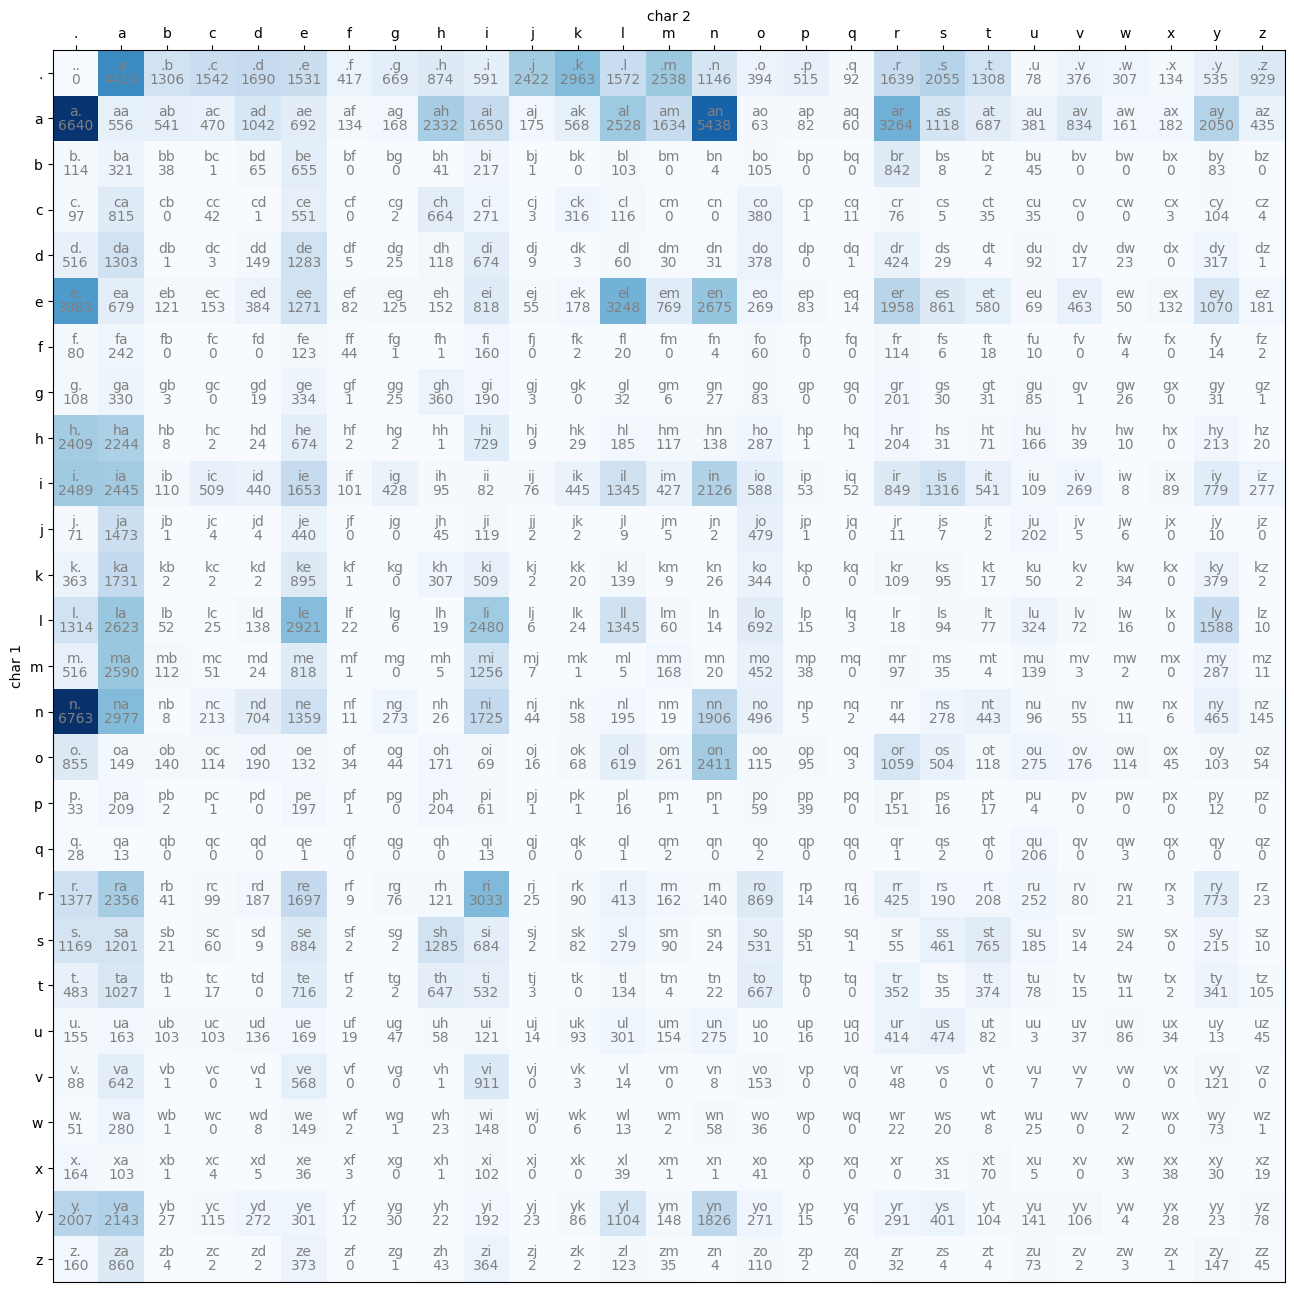

In [3]:
import torch
import matplotlib.pyplot as plt

chars = ["."] + sorted(list(set("".join(words))))
ctoi = {c: i for i, c in enumerate(chars)}
print(ctoi)

N = torch.zeros((len(chars), len(chars)), dtype=torch.int32)

for w in words:
    chrs = ["."] + list(w) + ["."]
    for c1, c2 in zip(chrs, chrs[1:]):
        N[ctoi[c1], ctoi[c2]] += 1

fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(N, cmap="Blues")

ax.set_xticks(range(len(chars)), chars)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_yticks(range(len(chars)), chars)

ax.xaxis.set_label_position("top")
ax.set_xlabel("char 2", )
ax.set_ylabel("char 1")

itoc = {i:c for c,i in ctoi.items()}

for i in range(len(chars)):
    for j in range(len(chars)):
        ax.text(j, i, itoc[i]+itoc[j], ha="center", va="bottom", color="gray")
        ax.text(j, i, N[i][j].item(), ha="center", va="top", color="gray")

In [4]:
P = N / N.sum(dim=1, keepdim=True)

g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    new_word = ["."]
    while True:
        idx = ctoi[new_word[-1]]
        probs = P[idx]
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        new_word.append(itoc[idx])

        if new_word[-1] == ".":
            new_word = "".join(new_word)
            break

    print(new_word)

.junide.
.janasah.
.p.
.cony.
.a.
.nn.
.kohin.
.tolian.
.juee.
.ksahnaauranilevias.


In [5]:
P = N + 1.0  # Smooth, also to avoid -inf log prob, log(0) = -inf. Alt is to add eps to log.
P /= P.sum(dim=1, keepdim=True)

g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    new_word = ["."]
    while True:
        idx = ctoi[new_word[-1]]
        probs = P[idx]
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        new_word.append(itoc[idx])

        if new_word[-1] == ".":
            new_word = "".join(new_word)
            break

    print(new_word)

.junide.
.janasah.
.p.
.cony.
.a.
.nn.
.kohin.
.tolian.
.juee.
.ksahnaauranilevias.


In [6]:
# Goal: maximize likelihood of data wrt model parameters.
# Equivalent to maximizing log likelihood, since log is monotonically increases (also stronger deriv closer to 0).
# Equivalent to minimizing the Negative Log Likelihood.
# Equivalent to minimizing mean NLL (our loss function).

log_likelihood = 0.0
n = 0
for w in words:
    chrs = ["."] + list(w) + ["."]
    for c1, c2 in zip(chrs, chrs[1:]):
        prob = P[ctoi[c1], ctoi[c2]]
        log_prob = torch.log(prob)

        log_likelihood += log_prob
        n += 1

        # print(f"{c1}{c2} {prob:.4f} {log_prob:.4f}")

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")

mean_nll = nll / n
print(f"{mean_nll=}")

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
mean_nll=tensor(2.4544)


# Bigram NN

In [7]:
xs, ys = [], []
for w in words[:1]:
    chrs = ["."] + list(w) + ["."]
    for c1, c2 in zip(chrs, chrs[1:]):
        print(c1, c2)
        xs.append(ctoi[c1])
        ys.append(ctoi[c2])

xs = torch.tensor(xs, dtype=torch.int64)
ys = torch.tensor(ys, dtype=torch.int64)

print(len(xs), len(ys))
print(xs[:10], ys[:10])

. e
e m
m m
m a
a .
5 5
tensor([ 0,  5, 13, 13,  1]) tensor([ 5, 13, 13,  1,  0])


['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([5, 27])


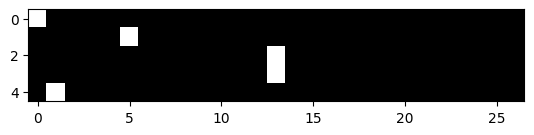

In [8]:
import torch.nn.functional as F

print(chars)
N_CHARS = len(chars)

xs_1hot = F.one_hot(xs, num_classes=N_CHARS).to(dtype=torch.float32)
print(xs_1hot)
print(xs_1hot.shape)

plt.imshow(xs_1hot, cmap="bone");

In [9]:
g = torch.Generator().manual_seed(2147483647)

W = torch.randn((27, 27), generator=g)
logits = xs_1hot @ W  # log-counts. Can be negative, all over Reals.

counts = logits.exp()  # counts. Can be positive. Similar to N matrix.
probs = counts / counts.sum(dim=-1, keepdim=True) # probs. all rows sum to 1. We just did a softmax to go from logits to probs.

print(probs.shape)
probs

torch.Size([5, 27])


tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

In [10]:
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()

    print(f"\nExample {i}")
    print(f"input, target: {itoc[x], itoc[y]}  {x, y}")
    
    print(f"preds: {probs[i]}")
    p = probs[i][y]
    print(f"target prob: {p.item()}")
    log_p = p.log()
    print(f"target log prob: {log_p.item()}")
    nll = -log_p
    print(f"nll: {nll.item()}")
    
    nlls[i] = nll

print(f"\nMean nll (loss): {nlls.mean().item()}")


Example 0
input, target: ('.', 'e')  (0, 5)
preds: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
target prob: 0.01228625513613224
target log prob: -4.399273872375488
nll: 4.399273872375488

Example 1
input, target: ('e', 'm')  (5, 13)
preds: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
target prob: 0.018050700426101685
target log prob: -4.014570713043213
nll: 4.014570713043213

Example 2
input, target: ('m', 'm')  (13, 13)
preds: tensor([0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
        0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
        0.0650

In [11]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

# Forward.
x_1hot = F.one_hot(xs, num_classes=27).to(dtype=torch.float32)
logits = x_1hot @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

# Collect the probs the NN assigns to the correct outputs.
# alt probs[torch.arange(probs.shape[0]), ys].
target_probs = probs.gather(dim=1, index=ys.unsqueeze(1)).view(-1)
loss = -target_probs.log().mean()
print(loss)

# Backward.
W.grad = None
loss.backward()

W.data -= 0.1 * W.grad

tensor(3.7693, grad_fn=<NegBackward0>)


## Putting it together

In [12]:
# Create dataset.
xs, ys = [], []
for w in words:
    chrs = ["."] + list(w) + ["."]
    for c1, c2 in zip(chrs, chrs[1:]):
        print(c1, c2)
        xs.append(ctoi[c1])
        ys.append(ctoi[c2])

xs = torch.tensor(xs, dtype=torch.int64)
ys = torch.tensor(ys, dtype=torch.int64)

print(len(xs), len(ys))
print(xs[:10], ys[:10])

. e
e m
m m
m a
a .
. o
o l
l i
i v
v i
i a
a .
. a
a v
v a
a .
. i
i s
s a
a b
b e
e l
l l
l a
a .
. s
s o
o p
p h
h i
i a
a .
. c
c h
h a
a r
r l
l o
o t
t t
t e
e .
. m
m i
i a
a .
. a
a m
m e
e l
l i
i a
a .
. h
h a
a r
r p
p e
e r
r .
. e
e v
v e
e l
l y
y n
n .
. a
a b
b i
i g
g a
a i
i l
l .
. e
e m
m i
i l
l y
y .
. e
e l
l i
i z
z a
a b
b e
e t
t h
h .
. m
m i
i l
l a
a .
. e
e l
l l
l a
a .
. a
a v
v e
e r
r y
y .
. s
s o
o f
f i
i a
a .
. c
c a
a m
m i
i l
l a
a .
. a
a r
r i
i a
a .
. s
s c
c a
a r
r l
l e
e t
t t
t .
. v
v i
i c
c t
t o
o r
r i
i a
a .
. m
m a
a d
d i
i s
s o
o n
n .
. l
l u
u n
n a
a .
. g
g r
r a
a c
c e
e .
. c
c h
h l
l o
o e
e .
. p
p e
e n
n e
e l
l o
o p
p e
e .
. l
l a
a y
y l
l a
a .
. r
r i
i l
l e
e y
y .
. z
z o
o e
e y
y .
. n
n o
o r
r a
a .
. l
l i
i l
l y
y .
. e
e l
l e
e a
a n
n o
o r
r .
. h
h a
a n
n n
n a
a h
h .
. l
l i
i l
l l
l i
i a
a n
n .
. a
a d
d d
d i
i s
s o
o n
n .
. a
a u
u b
b r
r e
e y
y .
. e
e l
l l
l i
i e
e .
. s
s t


In [13]:
# Init network.
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

for i in range(100):
    # Forward.
    x_1hot = F.one_hot(xs, num_classes=27).to(dtype=torch.float32)
    logits = x_1hot @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)

    # Collect the probs the NN assigns to the correct outputs.
    # alt probs[torch.arange(probs.shape[0]), ys].
    target_probs = probs.gather(dim=1, index=ys.unsqueeze(1)).view(-1)
    loss = -target_probs.log().mean()
    print(f"{i}: loss={loss}")

    # Backward.
    W.grad = None
    loss.backward()

    W.data -= 50.0 * W.grad

0: loss=3.758953809738159
1: loss=3.371098756790161
2: loss=3.1540417671203613
3: loss=3.020373821258545
4: loss=2.9277119636535645
5: loss=2.860402822494507
6: loss=2.8097293376922607
7: loss=2.7701027393341064
8: loss=2.7380733489990234
9: loss=2.711496591567993
10: loss=2.6890034675598145
11: loss=2.6696884632110596
12: loss=2.6529300212860107
13: loss=2.638277292251587
14: loss=2.6253881454467773
15: loss=2.6139907836914062
16: loss=2.603863477706909
17: loss=2.5948219299316406
18: loss=2.586712121963501
19: loss=2.57940411567688
20: loss=2.572789192199707
21: loss=2.5667762756347656
22: loss=2.5612881183624268
23: loss=2.5562589168548584
24: loss=2.551633596420288
25: loss=2.547365665435791
26: loss=2.5434155464172363
27: loss=2.539748430252075
28: loss=2.5363364219665527
29: loss=2.5331544876098633
30: loss=2.5301806926727295
31: loss=2.5273969173431396
32: loss=2.5247862339019775
33: loss=2.522334575653076
34: loss=2.520029067993164
35: loss=2.517857789993286
36: loss=2.51581096

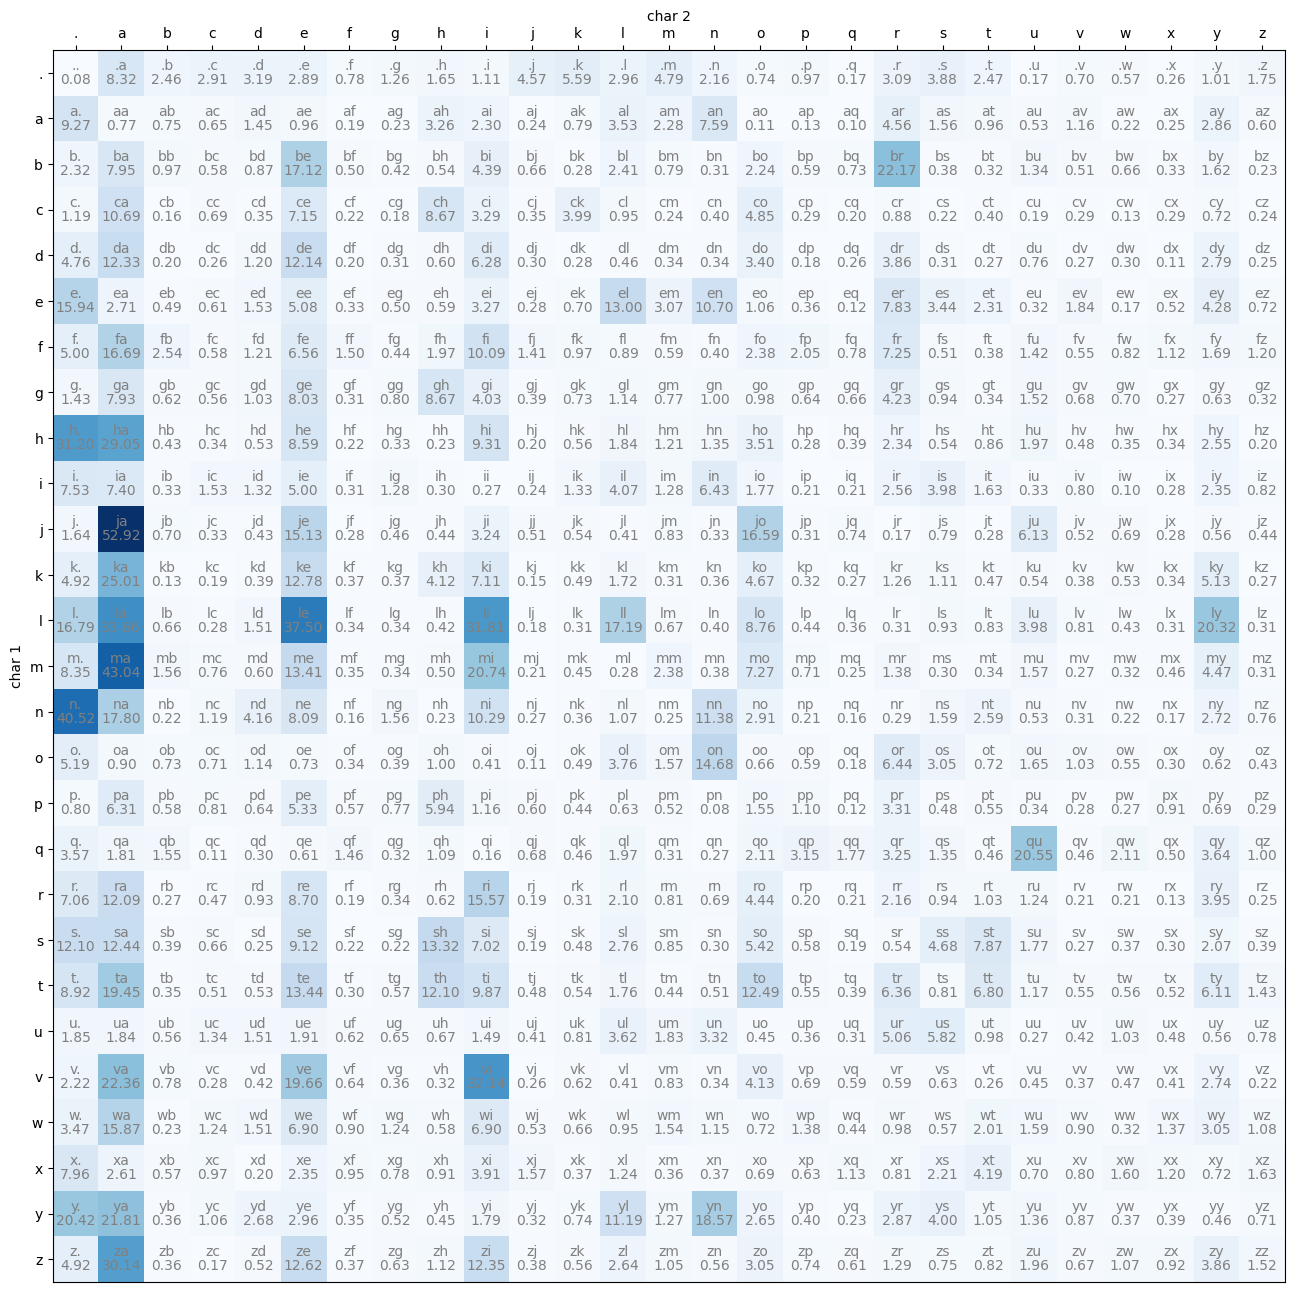

In [14]:
# Since x_1hot @ W plucks out rows from W, and these are interpreted as logits, W.exp() is literally just the gradient based approximation of N.
N_new = W.exp().detach().numpy()

fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(N_new, cmap="Blues")

ax.set_xticks(range(len(chars)), chars)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_yticks(range(len(chars)), chars)

ax.xaxis.set_label_position("top")
ax.set_xlabel("char 2", )
ax.set_ylabel("char 1")

itoc = {i:c for c,i in ctoi.items()}

for i in range(len(chars)):
    for j in range(len(chars)):
        ax.text(j, i, itoc[i]+itoc[j], ha="center", va="bottom", color="gray")
        ax.text(j, i, f"{N_new[i][j].item():.2f}", ha="center", va="top", color="gray")

In [15]:
# Label smoothing is like l2-regularization.
# Label smoothing: spreads out probability distribution
# Incentivizing W to 0: also spreads out prob dist since W = 0 corresponds to uniform distribution. 

# Init network.
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

for i in range(100):
    # Forward.
    x_1hot = F.one_hot(xs, num_classes=27).to(dtype=torch.float32)
    logits = x_1hot @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)

    # Collect the probs the NN assigns to the correct outputs.
    # alt probs[torch.arange(probs.shape[0]), ys].
    target_probs = probs.gather(dim=1, index=ys.unsqueeze(1)).view(-1)
    nll = -target_probs.log().mean()

    l2_loss = 0.01 * (W ** 2.0).mean()

    loss = nll + l2_loss
    print(f"{i}: loss={loss}")

    # Backward.
    W.grad = None
    loss.backward()

    W.data -= 50.0 * W.grad

0: loss=3.7686190605163574
1: loss=3.378804922103882
2: loss=3.1610896587371826
3: loss=3.0271859169006348
4: loss=2.9344847202301025
5: loss=2.867231607437134
6: loss=2.816654920578003
7: loss=2.777147054672241
8: loss=2.7452545166015625
9: loss=2.7188305854797363
10: loss=2.6965057849884033
11: loss=2.6773722171783447
12: loss=2.6608052253723145
13: loss=2.6463513374328613
14: loss=2.633665084838867
15: loss=2.622471332550049
16: loss=2.6125471591949463
17: loss=2.6037065982818604
18: loss=2.595794439315796
19: loss=2.5886802673339844
20: loss=2.5822560787200928
21: loss=2.5764291286468506
22: loss=2.5711236000061035
23: loss=2.566272497177124
24: loss=2.5618226528167725
25: loss=2.5577261447906494
26: loss=2.5539438724517822
27: loss=2.550442695617676
28: loss=2.5471925735473633
29: loss=2.5441696643829346
30: loss=2.5413522720336914
31: loss=2.538721799850464
32: loss=2.536261796951294
33: loss=2.5339579582214355
34: loss=2.531797409057617
35: loss=2.529768228530884
36: loss=2.5278

In [16]:
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    new_word = ["."]
    while True:
        x_1hot = F.one_hot(torch.tensor([ctoi[new_word[-1]]]), num_classes=27).to(dtype=torch.float32)
        logits = x_1hot @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)

        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        new_word.append(itoc[idx])

        if idx == 0:
            new_word = "".join(new_word)
            break

    print(new_word)

.junide.
.janasah.
.p.
.cfay.
.a.
.nn.
.kohin.
.tolian.
.juwe.
.kalanaauranilevias.
